In [ ]:
!unzip pgmpy.zip -d pgmpy

# Naive bayes and TAN on the Votes dataset

In [135]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from pgmpy.models import NaiveBayes, BayesianModel
from pgmpy.inference import VariableElimination
from estimators import TreeAugmentedNaiveBayesSearch, BNAugmentedNaiveBayesSearch, ForestAugmentedNaiveBayesSearch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data reading

In [136]:
df = pd.read_csv('votes.data', na_values=[' ?'])
df.head()

,class,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,republican,n,y,n,y,y,y,n,n,n,y,y,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
2,democrat,y,y,y,y,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,y,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,y,y,y,y,y


In [137]:
df.describe()

,class,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
count,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,236,243,264,247,227,283,253,257,229,223,264,233,234,265,233,373


## Data pre-processing

### Strip leading and trailing spaces from column names and cell values

In [138]:
df.columns = df.columns.str.strip()
for column in df.columns.values:
    if df[column].dtype == 'object':
        df[column] = df[column].str.strip()
df.columns.values

array(['class', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
       'L', 'M', 'N', 'O', 'P'], dtype=object)

### Record variable names and the target variable

In [139]:
variables_names = df.columns.values
target_variable = variables_names[0]
feature_variables = variables_names[1:]
print(feature_variables)
print(target_variable)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P']
class


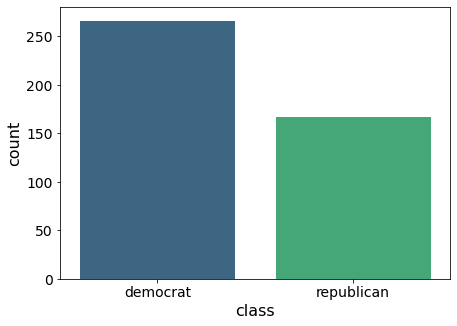

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(7,5), sharex=True)
sns.countplot(data=df, x='class',edgecolor="white",palette="viridis",order=df['class'].value_counts().index)
total = df['class'].value_counts().sum()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('class', fontsize=16)
plt.ylabel('count', fontsize=16)

plt.show()

## Train/test split & utilities

In [141]:
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]
test_no_target = test.copy().drop(target_variable, axis=1).reset_index()
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

Training set shape: (352, 17)
Test set shape: (83, 17)


Store every possible state for each variable:

In [142]:
state_names = {name: column.unique() for name, column in df.iteritems()}

## Naive Bayes model

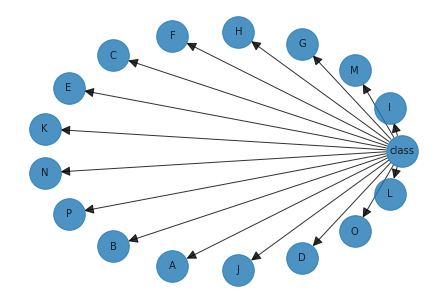

CPU times: user 326 ms, sys: 218 ms, total: 544 ms
Wall time: 306 ms


In [143]:
%%time
nb_model = NaiveBayes(
    feature_vars=feature_variables,
    dependent_var=target_variable
)
nx.draw_circular(nb_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

## TAN (Tree-Augmented Naive Bayes) 

/content/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


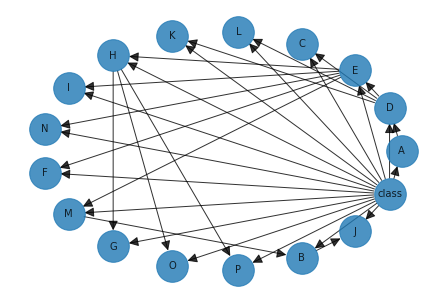

CPU times: user 616 ms, sys: 223 ms, total: 839 ms
Wall time: 609 ms


In [144]:
%%time
tan_estimator = TreeAugmentedNaiveBayesSearch(data=df, class_node=target_variable)
tan_structure = tan_estimator.estimate()
tan_model = BayesianModel(tan_structure.edges)
nx.draw_circular(tan_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

The TAN model, without the target variable, is a tree.


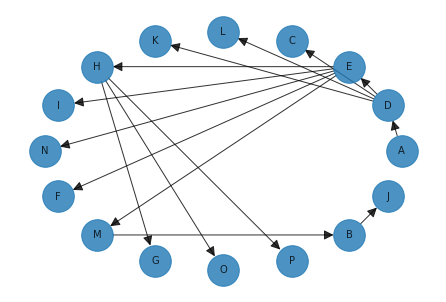

In [145]:
tree_check = tan_structure.copy()
tree_check.remove_node(target_variable)
if nx.is_tree(tree_check):
    print('The TAN model, without the target variable, is a tree.')
else:
    print('The TAN model, without the target variable, is not a tree.')
nx.draw_circular(tree_check, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)